# SPR data models
This notebook is to collaborate on modelling enzyme kinetics on SPR data.

## Reversible binding model
ref: https://pubmed.ncbi.nlm.nih.gov/22966968/

$$
E_{bulk} + \Gamma_O \underset{k_{\text{off}}}{\overset{k_{\text{on}}}{\leftrightarrows}} \Gamma_E
$$

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.integrate import odeint
import os

def process_data(time, R, time_max=60, plot_this=False):
    time_cut = time[time < time_max]
    R_cut = R[time < time_max]

    xmin=0

    # Optional: Smooth the data to reduce noise using Savitzky-Golay filter
    window_length = 51  # Must be an odd number; adjust as needed
    polyorder = 3
    R_cut_smooth = savgol_filter(R_cut, window_length, polyorder)

    if plot_this:
    # Plot the original and smoothed data to visualize smoothing effect
        plt.figure(figsize=(10, 6))
        plt.plot(time_cut, R_cut, label='Original Data', alpha=0.5)
        plt.plot(time_cut, R_cut_smooth, label='Smoothed Data', linewidth=2)
        plt.xlabel('Time')
        plt.ylabel('Signal')
        plt.title('Signal vs Time (Cut Data)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Step 2: Calculate the derivative of the smoothed data
    dR_dt = np.gradient(R_cut_smooth, time_cut)

    if plot_this:
    # Plot the derivative to visualize where the signal starts to rise
        plt.figure(figsize=(10, 6))
        plt.plot(time_cut, dR_dt)
        plt.xlabel('Time')
        plt.ylabel('dR/dt')
        plt.title('Derivative of Signal vs Time')
        plt.grid(True)
        plt.show()

    # Set a threshold for the derivative to detect where the baseline ends
    # Adjust the threshold based on your data characteristics
    threshold = np.max(dR_dt) * 0.2  # For example, 20% of the maximum derivative

    # Find the index where the derivative first exceeds the threshold
    baseline_end_indices = np.where(dR_dt > threshold)[0]

    if len(baseline_end_indices) > 0:
        baseline_end_index = baseline_end_indices[0]
        t_baseline_end = time_cut[baseline_end_index]
        print(f"Automatically detected t_baseline_end at time {t_baseline_end}")
    else:
        print("Could not automatically detect t_baseline_end; defaulting to xmin")
        t_baseline_end = xmin

    # Step 3: Normalize the data using R_normalized(t) = (R(t) - R_baseline) / (R_max - R_baseline)
    # Calculate R_baseline as the mean of R_cut during the baseline period
    baseline_indices = np.where(time_cut <= t_baseline_end)
    R_baseline = np.mean(R_cut[baseline_indices[0]])

    # Calculate R_max as the maximum value of R_cut after the baseline
    post_baseline_indices = np.where(time_cut > t_baseline_end)
    R_max = np.max(R_cut[post_baseline_indices[0]])

    # Normalize R(t)
    R_normalized = (R_cut - R_baseline) / (R_max - R_baseline)

    # Step 4: Cut off the initial flat (baseline) part
    # Extract data after t_baseline_end
    time_final = time_cut[post_baseline_indices[0]]
    R_normalized_final = R_normalized[post_baseline_indices[0]]

    # Rescale the time axis to start at zero at t_baseline_end
    time_rescaled = time_final - t_baseline_end
    t_signal_start = np.gradient(R_normalized_final, time_rescaled).argmax()
    R_normalized_final_tmp = R_normalized_final.values[t_signal_start:]
    while R_normalized_final_tmp[0]>0.1:
        t_signal_start -= 1
        R_normalized_final_tmp = R_normalized_final.values[t_signal_start:]
    time_rescaled = time_rescaled.values[t_signal_start:]
    R_normalized_final = R_normalized_final_tmp

    if plot_this:
    # Plot the final normalized data with rescaled time axis
        plt.figure(figsize=(10, 6))
        plt.plot(time_rescaled, R_normalized_final)
        plt.xlabel('Time since baseline end')
        plt.ylabel('Normalized Signal')
        plt.title('Normalized Signal vs Time (After Baseline Removal)')
        plt.grid(True)
        plt.show()
    return time_rescaled, R_normalized_final, R_max

def enzyme_adsorption_model(y, t, ka, kd, Gamma_max, transition_time):
    """
    ODE system for enzyme adsorption with reversible and irreversible binding
    y[0] = Gamma_E (reversibly bound enzyme)
    """
    Gamma_E = y
    Gamma_0 = Gamma_max - Gamma_E  # Available binding sites

    # During adsorption phase, E_bulk > 0
    if t < transition_time:  
        dGamma_E_dt = ka * E_bulk * Gamma_0 - kd * Gamma_E
    # During washoff phase, E_bulk = 0
    else:
        dGamma_E_dt = -kd * Gamma_E

    return dGamma_E_dt

# Function to simulate the complete adsorption and washoff process
def simulate_adsorption_washoff(t, ka, kd, Gamma_max, transition_time):
    # Initial conditions: no bound enzyme
    y0 = [0.0]  # [Gamma_E]

    # Solve the ODE system
    solution = odeint(enzyme_adsorption_model, y0, t, args=(ka, kd, Gamma_max, transition_time))
    # Total surface enzyme = reversibly bound + irreversibly bound
    Gamma_T = solution[:, 0]

    return Gamma_T



def MSE(params,x_data,y_data):
    "to calclate mean square error, this is the same as your func_error"
    return ((simulate_adsorption_washoff(x_data,*params)-y_data)**2).mean()

def fit_model(time_rescaled, R_normalized_final, E_bulk=5e-6, plot_this=False):
    # Define the ODE system based on equations 2 and 3
 
    besterror = 10000
    bestpopt = None

    for kon_ in np.arange(1e5,1e6,1e4):
        for tt_ in np.arange(8,20,0.5):
            # grid search for parameter c between 5 and 100, step size is 1.
            popt, pcov = curve_fit(simulate_adsorption_washoff,
                            time_rescaled,
                            R_normalized_final,
                            p0=[kon_, 0.01, 1.0, tt_],  # Initial guesses for ka, kd, ki, Gamma_max, transition_time
                            bounds=([kon_, 0, 0, tt_], [kon_+1e4, 1, 2, tt_+1]))  # Reasonable bounds
                                       
            error = MSE(popt,time_rescaled,R_normalized_final)
            if error<besterror:
                besterror = error 
                bestpopt = popt

    return bestpopt, error

    # Fit the entire dataset with a single set of parameters

def plot_best_popt(bestpopt, x_data, y_data):

    ka_fitted, kd_fitted, Gamma_max_fitted, transition_time_fitted = bestpopt
    print(f"Fitted parameters:")
    print(f"ka: {ka_fitted:.6f}")
    print(f"kd: {kd_fitted:.6f}")
    print(f"Gamma_max: {Gamma_max_fitted:.6f}")
    print(f"transition_time: {transition_time_fitted:.6f}")


    error = MSE(bestpopt, x_data, y_data)
    print(f"MSE: {error:.6f}")


    # Decompose the result to show Gamma_E and Gamma_I separately
    solution = odeint(enzyme_adsorption_model, y0=[0], t=x_data, args=(ka_fitted, kd_fitted, Gamma_max_fitted, transition_time_fitted))
    Gamma_E = solution[:, 0] 

    plt.figure(figsize=(12, 6))
    plt.plot(x_data, y_data, 'o', alpha=0.5, label='Experimental data')
    plt.plot(x_data, Gamma_E, 'g-', linewidth=2, label='Reversibly bound (Γ_E)')


    plt.axvline(x=transition_time_fitted, color='k', linestyle='--',
                label=f'Washoff at {transition_time_fitted:.1f} min')

    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Normalized signal', fontsize=14)
    plt.title('Decomposition of Enzyme Binding into Reversible and Irreversible Components', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()




Automatically detected t_baseline_end at time 14.6365
Fitted parameters:
ka: 460000.000060
kd: 0.012268
Gamma_max: 0.956458
transition_time: 8.000000
MSE: 0.001413


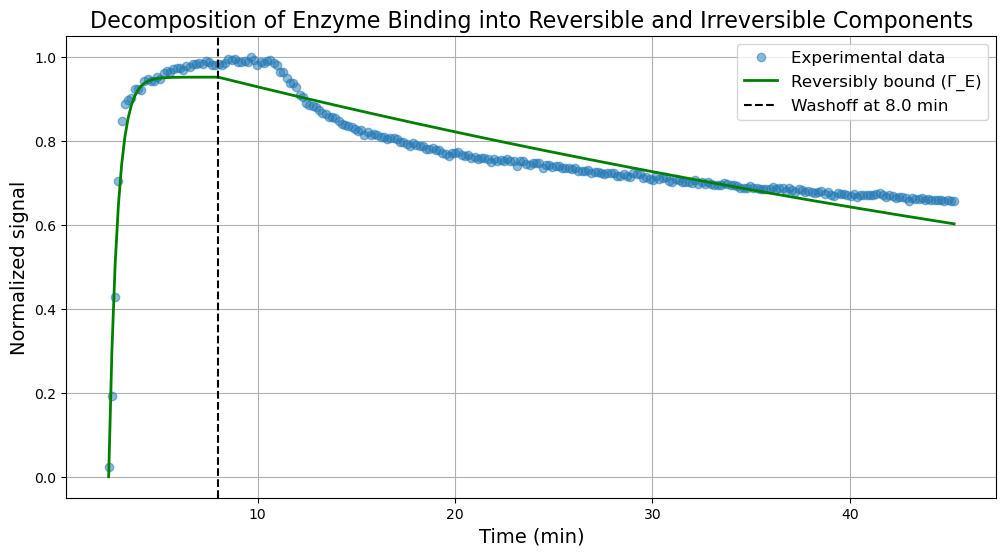

Automatically detected t_baseline_end at time 5.60083
Fitted parameters:
ka: 954468.572626
kd: 0.004248
Gamma_max: 1.714855
transition_time: 18.505921
MSE: 0.001539


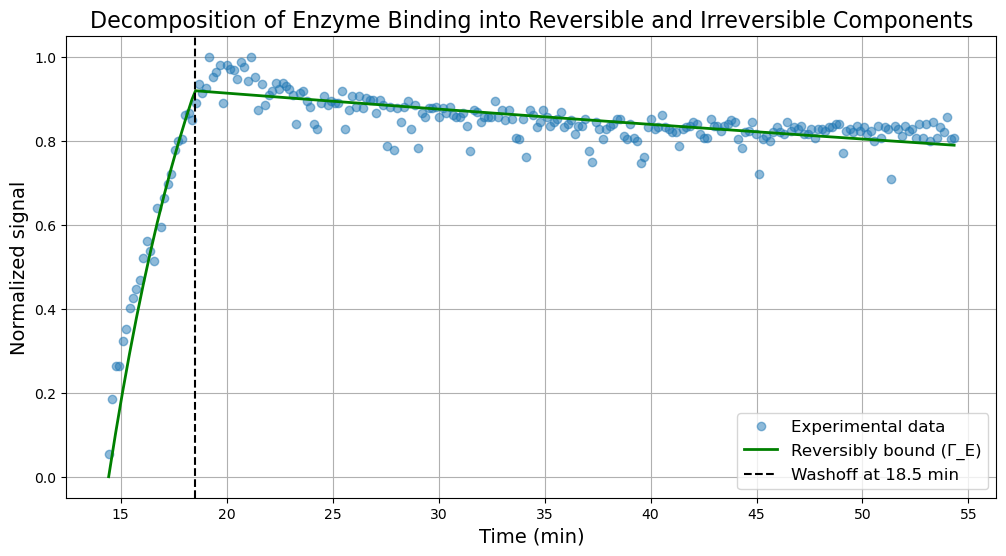

Automatically detected t_baseline_end at time 16.0899
Fitted parameters:
ka: 551068.176789
kd: 0.001767
Gamma_max: 1.188073
transition_time: 8.022138
MSE: 0.000234


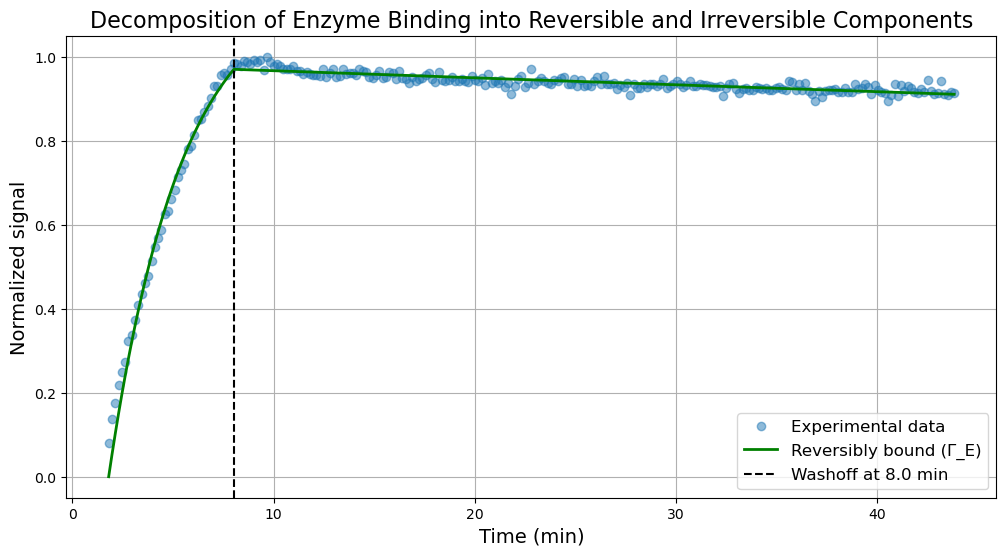

Automatically detected t_baseline_end at time 15.2701
Fitted parameters:
ka: 369980.094172
kd: 0.001367
Gamma_max: 1.129403
transition_time: 10.556105
MSE: 0.000244


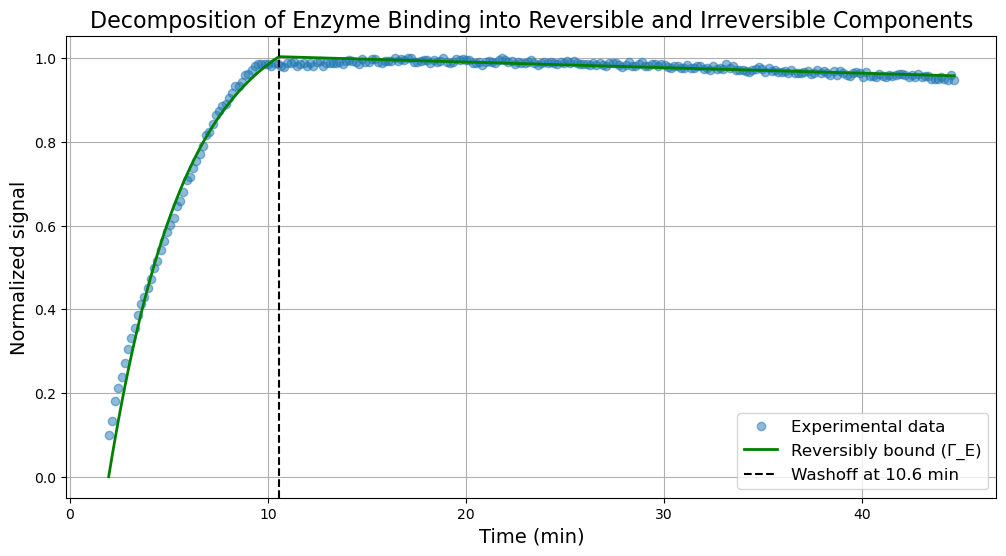

Automatically detected t_baseline_end at time 16.0721
Fitted parameters:
ka: 330446.781365
kd: 0.009112
Gamma_max: 1.093666
transition_time: 8.014131
MSE: 0.001283


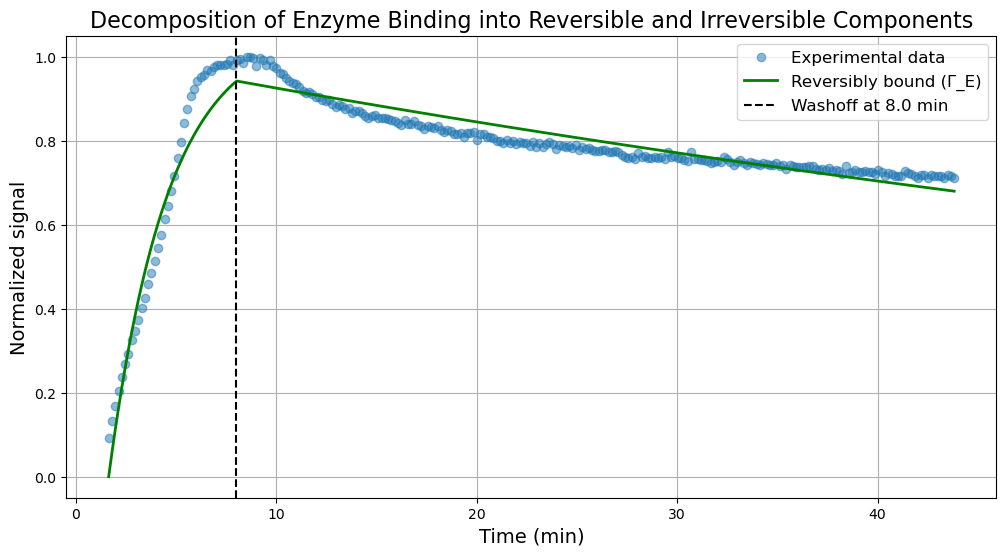

Automatically detected t_baseline_end at time 16.7547
Fitted parameters:
ka: 820266.395006
kd: 0.011524
Gamma_max: 0.963954
transition_time: 8.000000
MSE: 0.001065


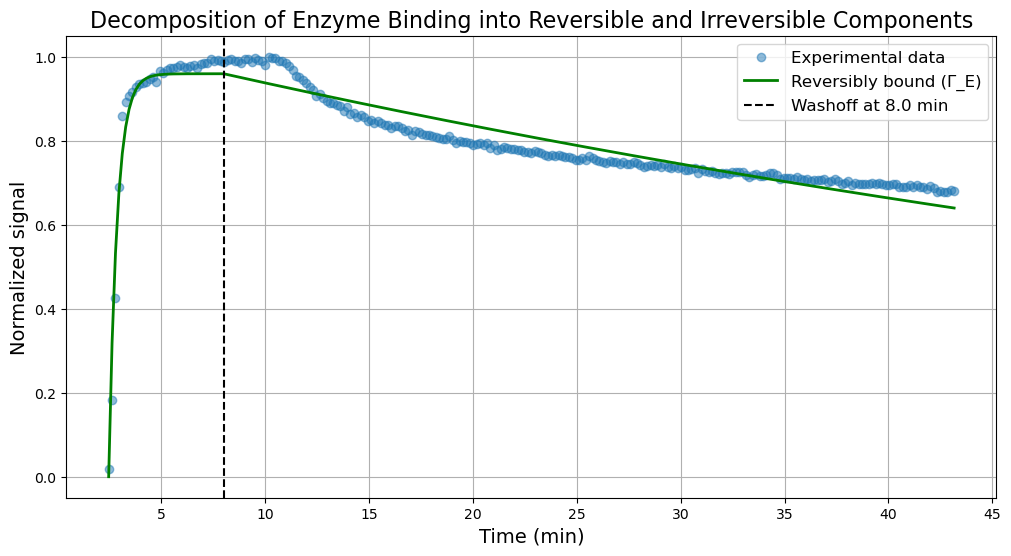

In [ ]:
file_list = []
data_dir = 'SPR_data'
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if '0.25% PET' in file:
            file_list.append(file)
results = {
    'kon': [],
    'koff': [],
    'Gamma_max':[],
    'transition_time':[],
    'E_bulk': [],
    'R_max': [],
    'time_rescaled':[],
    'R_normalized_final':[],
    'MSE':[]
}

for file in file_list:
    E_bulk = float(file.split('-')[2].split(' ')[1]) * 1e-6
    df = pd.read_csv(f'{data_dir}/{file}', sep='\t', decimal=',')
    time = df[df.columns[2]]*60
    R = df[df.columns[3]]
    #plt.plot(time, R)
    time_rescaled, R_normalized_final, R_max = process_data(time, R)
    bestpopt, error = fit_model(time_rescaled, R_normalized_final, E_bulk)
    results['kon'].append(bestpopt[0])
    results['koff'].append(bestpopt[1])
    results['Gamma_max'].append(bestpopt[2])
    results['transition_time'].append(bestpopt[3])
    results['MSE'].append(error)
    results['E_bulk'].append(E_bulk)
    results['R_max'].append(R_max)
    results['R_normalized_final'].append(R_normalized_final)
    results['time_rescaled'].append(time_rescaled)
    plot_best_popt(bestpopt, time_rescaled, R_normalized_final)

In [18]:
results_df = pd.DataFrame(results)
results_df.head()

,kon,koff,Gamma_max,transition_time,E_bulk,R_max,time_rescaled,R_normalized_final,MSE
0,460000.000060,0.012268,0.956458,8.000000,5.000000e-06,73.6556,"[2.4566, 2.620800000000001, 2.7844999999999995...","[0.02317005504951103, 0.1915698779932504, 0.42...",0.005163
1,954468.572626,0.004248,1.714855,18.505921,2.000000e-07,73.3030,"[14.438170000000001, 14.60187, 14.765569999999...","[0.053734939758748726, 0.18481927710846585, 0....",0.002737
2,551068.176789,0.001767,1.188073,8.022138,5.000000e-07,73.3875,"[1.8038999999999987, 1.9673000000000016, 2.130...","[0.08028894546751209, 0.1373477806067204, 0.17...",0.002363
3,369980.094172,0.001367,1.129403,10.556105,7.000000e-07,73.4964,"[1.9677000000000007, 2.131700000000002, 2.2954...","[0.09936207514641388, 0.13270212003197177, 0.1...",0.007025
4,330446.781365,0.009112,1.093666,8.014131,1.000000e-06,73.6112,"[1.637900000000002, 1.8020999999999994, 1.9661...","[0.09168296975689616, 0.13333473574968177, 0.1...",0.015148


In [20]:
results_df['KD'] = results_df['koff']/results_df['kon']
results_df[results_df['E_bulk'] >= 1.0e-6].describe()

,kon,koff,Gamma_max,transition_time,E_bulk,R_max,MSE,KD
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000e+00
mean,536904.392143,0.010968,1.004693,8.004710,0.000003,73.635133,0.009954,2.276425e-08
std,253804.112690,0.001650,0.077144,0.008159,0.000002,0.022402,0.005005,7.561412e-09
min,330446.781365,0.009112,0.956458,8.000000,0.000001,73.611200,0.005163,1.404878e-08
25%,395223.390712,0.010318,0.960206,8.000000,0.000002,73.624900,0.007357,2.035881e-08
50%,460000.000060,0.011524,0.963954,8.000000,0.000003,73.638600,0.009551,2.666884e-08
75%,640133.197533,0.011896,1.028810,8.007066,0.000004,73.647100,0.012350,2.712199e-08
max,820266.395006,0.012268,1.093666,8.014131,0.000005,73.655600,0.015148,2.757514e-08


In [21]:
kin_kd = results_df[results_df['E_bulk'] >= 1.0e-6].describe().loc['mean', 'KD']*1e6
kin_kd_err = results_df[results_df['E_bulk'] >= 1.0e-6].describe().loc['std', 'KD']*1e6

print(f'Kinetic KD: {kin_kd:.3f} +/- {kin_kd_err:.3f} µM')

Kinetic KD: 0.023 +/- 0.008 µM


Equilibrium KD: 1.08 +/- 0.65 µM


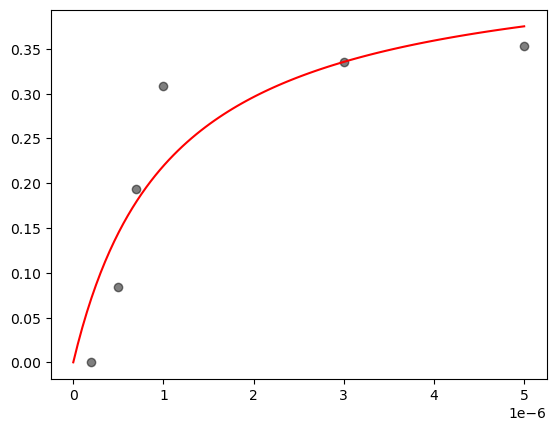

In [22]:
def langmuir(E,KD,Qmax):
    return E*Qmax/(KD+E)

x = results_df['E_bulk'].values
y = results_df['R_max'].values
y = y - y.min()
popt, pcov = curve_fit(langmuir, x, y)
perr = np.sqrt(np.diag(pcov))
print(f'Equilibrium KD: {popt[0]*1e6:.2f} +/- {perr[0]*1e6:.2f} µM')
plt.plot(x,y,'ko',alpha=0.5, label='data')
xmodel = np.linspace(0, x.max(), num=100)
plt.plot(xmodel, langmuir(xmodel, *popt), 'r-', label='fit')
plt.show()